# Data Handling

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import illustris_python as il

## General Imports and Path Definition

In [2]:
import illustris_python as il
import numpy as np
import pandas as pd
import os

In [3]:
# Set the base path for your TNG50-1 dataset
basePath = '../sims.TNG/TNG50-1/output/' 

## z = 0 Dataset

In [5]:
snap = 99  # Snapshot 99 corresponds to z = 0

# Load the subhalo (galaxy) catalog for snapshot 99.
# The 'fields' argument should list the quantities you need.
fields = ['SubhaloMassType', 'SubhaloSFR', 'SubhaloHalfmassRad', 'SubhaloBHMass', 'SubhaloFlag']
subhalo = il.groupcat.loadSubhalos(basePath, snap, fields=fields)

# For clarity, extract key properties from the returned dictionary.
# Here we assume SubhaloMassType is an array of shape (N_galaxies, 6),
# where index 0 = gas, 1 = dark matter, 4 = stars.
stellar_mass_99 = subhalo['SubhaloMassType'][:, 4]  # stellar mass
gas_mass_99     = subhalo['SubhaloMassType'][:, 0]  # gas mass
dm_mass_99      = subhalo['SubhaloMassType'][:, 1]  # dark matter mass

# Other properties directly from the catalog
sfr_99         = subhalo['SubhaloSFR']
halfmass_99    = subhalo['SubhaloHalfmassRad']
bh_mass_99     = subhalo['SubhaloBHMass']
flags_99       = subhalo['SubhaloFlag']

# Create a pandas dataframe.
df_snapshot99 = pd.DataFrame({
    'flags': flags_99,
    'stellar_mass': stellar_mass_99,
    'gas_mass': gas_mass_99,
    'dm_mass': dm_mass_99,
    'sfr': sfr_99,
    'halfmass': halfmass_99,
    'bh_mass': bh_mass_99
})

### Omit flagged data and data below target stellar mass threshold

In [6]:
# Total number of columns in the DataFrame
total_rows = len(df_snapshot99)

# Total number of rows where 'flags' is False
flagged_rows = len(df_snapshot99[df_snapshot99['flags'] == False])

# Print the results
print(f"Total number of rows: {total_rows}")
print(f"Total number of flagged rows (where 'flags' is False): {flagged_rows}")

# Omit flagged data from dataframe and then drop flags column
df_snapshot99 = df_snapshot99[df_snapshot99['flags'] == True]
df_snapshot99 = df_snapshot99.drop(columns=['flags'])

Total number of rows: 5688113
Total number of flagged rows (where 'flags' is False): 1349


In [7]:
# Drop rows where 'stellar_mass' is lower than 0.01 (10^8 solar masses)
df_snapshot99 = df_snapshot99[df_snapshot99['stellar_mass'] >= 0.01]

In [8]:
# Visualize filtered dataset
print(df_snapshot99.head())

   stellar_mass     gas_mass       dm_mass       sfr    halfmass   bh_mass
0    368.292999  1559.956543  11360.775391  1.157833  362.230286  0.579029
1     26.731363     0.005698    142.667740  0.000000   29.539518  0.054223
2     13.025371     0.227375    143.777634  0.000985   58.699230  0.029711
3      6.341208     0.004101     27.361473  0.000000   12.771269  0.020092
4      6.088575     0.000337     12.617106  0.000000    5.421579  0.019615


In [9]:
# Get length of filtered dataset
print(len(df_snapshot99))

7090


## Time-series Dataset

In [10]:
# ----------------------------------------------------
# 1. Define Parameters and Desired Snapshots
# ----------------------------------------------------

# We choose snapshots: start with 0, then every 5th snapshot starting with 4, up to 99.
desired_snaps = list(range(4, 100, 5))
print("Desired snapshots:", desired_snaps)

# ----------------------------------------------------
# 2. Select a Subset of the Most Massive Galaxies at z = 0 (Snapshot 99)
# ----------------------------------------------------

# Select the top 50 galaxies by stellar mass.
N = 50
# Get indices sorted by descending stellar mass.
sorted_indices = np.argsort(stellar_mass_99)[::-1]
selected_ids = sorted_indices[:N]
print("Selected galaxy IDs (from snapshot 99):", selected_ids)

##### This might be the correct way to get the first progenitor IDs
# GroupFirstSub = il.groupcat.loadHalos(basePath, 99, fields=['GroupFirstSub'])
# print(GroupFirstSub)

# ----------------------------------------------------
# 3. Define a Function to Extract the Main Branch from the Merger Tree
# ----------------------------------------------------
def get_main_branch_indices(tree):
    """
    Given a merger tree (as a dictionary with keys as arrays),
    extract the indices corresponding to the main branch.
    
    This function assumes that the tree dictionary contains the following fields:
      - 'SubhaloID': Unique identifier for each node in the tree.
      - 'FirstProgenitorID': Global unique ID of the first progenitor, or -1 if none.
    
    Returns:
        main_branch_indices (list): List of indices (into the tree arrays) along the main branch.
    """
    main_branch_indices = []
    i = 0  # Start at index 0 (the z = 0 galaxy)
    while i != -1:
        main_branch_indices.append(i)
        progenitor_global_id = int(tree['FirstProgenitorID'][i])
        if progenitor_global_id == -1:
            break
        # Find the index in the tree where 'SubhaloID' equals progenitor_global_id.
        idx_candidates = np.where(tree['SubhaloID'] == progenitor_global_id)[0]
        if len(idx_candidates) == 0:
            # No match found – break the chain.
            break
        i = int(idx_candidates[0])
    return main_branch_indices

# ----------------------------------------------------
# 4. Loop Over Each Selected Galaxy and Build the Time-Series Data
# ----------------------------------------------------
ts_data = []

# Define the fields to load from the merger tree.
# We now include 'SubhaloID' to allow proper mapping of progenitor pointers.
fields_tree = [
    'SubhaloID', 'SnapNum', 'SubhaloMassType', 'SubhaloSFR', 
    'SubhaloBHMass', 'SubhaloHalfmassRad', 
    'FirstProgenitorID', 'NextProgenitorID'
]

# Loop over each selected galaxy (identified in snapshot 99)
for gal_id in selected_ids:
    try:
        # Load the merger tree for this galaxy.
        tree = il.sublink.loadTree(basePath, 99, int(gal_id), fields=fields_tree)
    except Exception as e:
        print(f"Error loading tree for galaxy {gal_id}: {e}")
        continue

    # Get the indices along the main branch.
    main_branch_indices = get_main_branch_indices(tree)
    
    # Loop over each node in the main branch.
    for idx in main_branch_indices:
        snap = int(tree['SnapNum'][idx])
        if snap in desired_snaps:
            # Extract masses from SubhaloMassType (assumed to be an array).
            mass_array = tree['SubhaloMassType'][idx]
            stellar_mass = mass_array[4]   # stellar mass
            gas_mass     = mass_array[0]   # gas mass
            dm_mass      = mass_array[1]   # dark matter mass

            # Extract other properties.
            sfr      = tree['SubhaloSFR'][idx]
            bh_mass  = tree['SubhaloBHMass'][idx]
            halfmass = tree['SubhaloHalfmassRad'][idx]

            # Create a simple merger flag: if NextProgenitorID != -1, flag as a merger.
            merger_flag = 1 if int(tree['NextProgenitorID'][idx]) != -1 else 0

            # Append this snapshot's data for this galaxy.
            ts_data.append({
                'galaxy_id': int(gal_id), 
                'snapshot': snap,
                'stellar_mass': stellar_mass,
                'gas_mass': gas_mass,
                'dm_mass': dm_mass,
                'sfr': sfr,
                'bh_mass': bh_mass,
                'halfmass': halfmass,
                'merger_flag': merger_flag
            })

# Convert the collected time-series data into a Pandas DataFrame.
df_timeseries = pd.DataFrame(ts_data)

# Sort the dataframe for clarity: by galaxy_id and snapshot.
df_timeseries.sort_values(['galaxy_id', 'snapshot'], inplace=True)

Desired snapshots: [4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99]
Selected galaxy IDs (from snapshot 99): [     0  96762  63864 198182 117250 229933 208811 220595 253861 184931
 275545 289385 319730 300903 282779 294866 167392 242788 313692 329508
 167393      1 360923 324123 117251  63865 345872 338446 352426 143880
 242789 264883 307486 368843 143881 220596 143882 371126 333424 390932
 348901  63866 242790 355724 398784 358608 143885 143884 143883 410037]


In [11]:
print(df_timeseries.head(20))

    galaxy_id  snapshot  stellar_mass     gas_mass       dm_mass         sfr  \
19          0         4      0.000652     0.030481      0.462035    0.072198   
18          0         9      0.002787     0.028361      0.141789    0.466303   
17          0        14      0.387317     2.837860     20.995981   42.937717   
16          0        19      2.850027    10.157128     74.400932  178.597931   
15          0        24     17.085293    24.792549    263.700043  267.556580   
14          0        29     19.780106    69.358185    678.133850  151.254791   
13          0        34     34.272537   109.232330    930.244568  133.900391   
12          0        39     38.613739   171.908386   1315.221924  119.622688   
11          0        44     45.811619   240.817398   1736.152588   79.749054   
10          0        49     57.698219   326.379456   2298.177246  205.901611   
9           0        54     74.900833   495.445221   3342.263184  174.938278   
8           0        59     90.798470   

# Clustering for Classification at z = 99

## Initial GMM and Hierarchical Models

Columns in z=99 dataframe: ['stellar_mass', 'gas_mass', 'dm_mass', 'sfr', 'halfmass', 'bh_mass']
Original number of features: 6
Reduced number of features after PCA: 2
Explained variance ratio: [0.74699163 0.16202399]
GMM: n_clusters = 2, silhouette score = 0.660
GMM: n_clusters = 3, silhouette score = 0.642
GMM: n_clusters = 4, silhouette score = 0.398
GMM: n_clusters = 5, silhouette score = 0.309
GMM: n_clusters = 6, silhouette score = 0.309
GMM: n_clusters = 7, silhouette score = 0.126
GMM: n_clusters = 8, silhouette score = 0.126
GMM: n_clusters = 9, silhouette score = 0.126
GMM: n_clusters = 10, silhouette score = 0.127


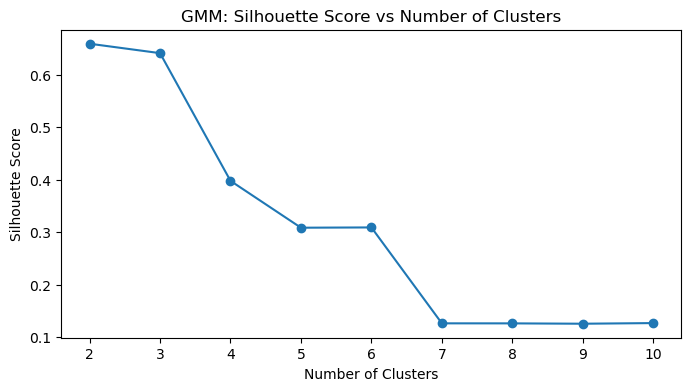

Best number of clusters for GMM based on silhouette score: 2


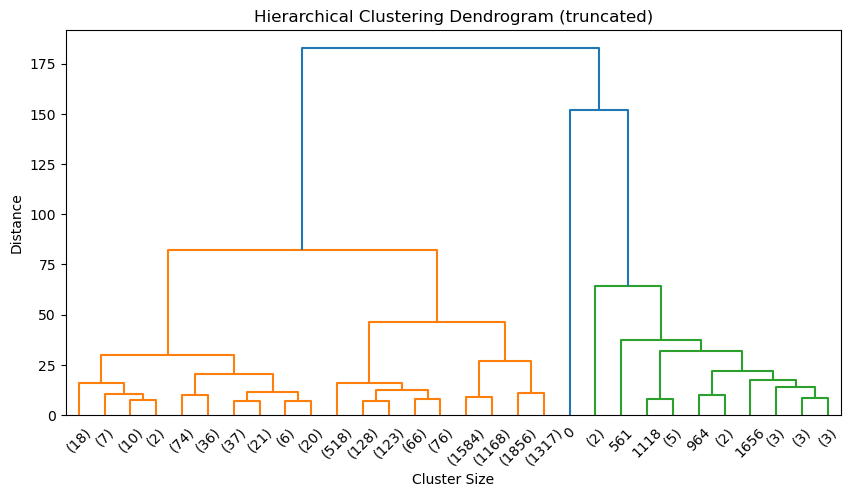

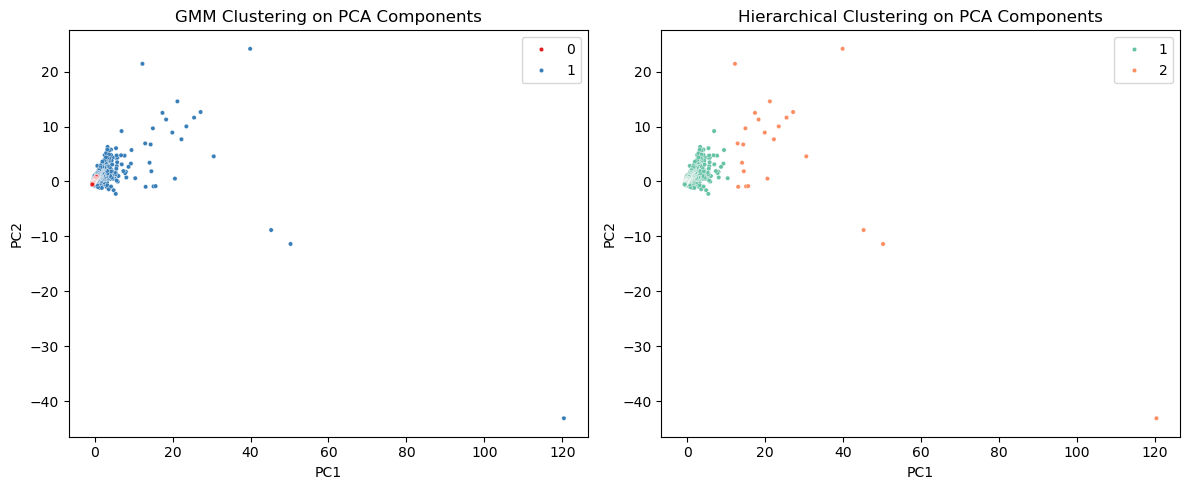

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Load or reference your data frame.
# Assume df_z99 is your z = 99 dataframe with ~7090 galaxies.
# For example:
# df_z99 = pd.read_csv("z99_galaxies.csv")  
# (Here, we assume you already have it in memory.)

# For demonstration, let's list the columns:
print("Columns in z=99 dataframe:", df_snapshot99.columns.tolist())

# -----------------------------
# 2. Data Preprocessing: Normalization and PCA
# -----------------------------
# Select the features you want to use in the clustering analysis.
# For example, let's use stellar_mass, gas_mass, dm_mass, sfr, halfmass, and bh_mass.
features = ['stellar_mass', 'gas_mass', 'dm_mass', 'sfr', 'halfmass', 'bh_mass']
X = df_snapshot99[features].values

# Normalize the data using StandardScaler.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce dimensionality.
# You can start with a PCA that preserves, say, 90% of the variance.
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)
print("Original number of features:", X.shape[1])
print("Reduced number of features after PCA:", X_pca.shape[1])
print("Explained variance ratio:", pca.explained_variance_ratio_)

# -----------------------------
# 3. Clustering Analysis using Gaussian Mixture Models (GMM)
# -----------------------------
# Let's try a range of cluster numbers (e.g., 2 to 10) and compute silhouette scores.
silhouette_scores = []
n_clusters_range = range(2, 11)
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_pca)
    labels = gmm.predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"GMM: n_clusters = {n_clusters}, silhouette score = {score:.3f}")

# Plot silhouette scores vs. number of clusters.
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("GMM: Silhouette Score vs Number of Clusters")
plt.show()

# Choose a number of clusters based on the silhouette score.
best_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
print("Best number of clusters for GMM based on silhouette score:", best_n_clusters)

# Fit GMM with the chosen number of clusters.
gmm_final = GaussianMixture(n_components=best_n_clusters, random_state=42)
gmm_final.fit(X_pca)
labels_gmm = gmm_final.predict(X_pca)
df_snapshot99['GMM_cluster'] = labels_gmm

# -----------------------------
# 4. Hierarchical Clustering
# -----------------------------
# Compute a linkage matrix using Ward's method.
linkage_matrix = sch.linkage(X_pca, method='ward')

# Plot the dendrogram to visually inspect the clustering structure.
plt.figure(figsize=(10, 5))
dendro = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

# Optionally, cut the dendrogram at a chosen number of clusters.
from scipy.cluster.hierarchy import fcluster
hier_labels = fcluster(linkage_matrix, t=best_n_clusters, criterion='maxclust')
df_snapshot99['Hier_cluster'] = hier_labels

# -----------------------------
# 5. Visualize the Clustering Results
# -----------------------------
# We can plot the PCA projection colored by the GMM and hierarchical clustering labels.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_gmm, palette="Set1", s=10)
plt.title("GMM Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hier_labels, palette="Set2", s=10)
plt.title("Hierarchical Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

PCA preserving 90% of the variance still reduced the feature set from 6 features to 2. This indicates to me that two features already dominated the variation prior to PCA, so it is likely that we can identify exactly what PC1 and PC2 are from the original data. 

Interestingly, we see that three clusters worked nearly as well for the GMM so it would be interesting to additionally visualize those results. I know from prior knowledge that galaxies are classified into three main types - ellipticals, spirals, and irregulars. It would therefore make sense if we ended up with three separate clusters, although this is not necessarily true since we are only looking at the most massive galaxies; it is possible that our biased sampling method is leading to an overidentification of one type of galaxy, e.g., if spiral galaxies are often the most massive then we may have oversampled that type of galaxy and should not actually expect three clusters. Additionally, the hierarchical clustering algorithm appears to want three clusters, but we are forcing it to have the same number of clusters as the GMM. If we consider that three clusters was nearly optimal for GMM, and that it is optimal for the hierarchical method, I think that we should use three clusters.

## Modified Approach With Three Clusters Based On Previous Results and Discussion

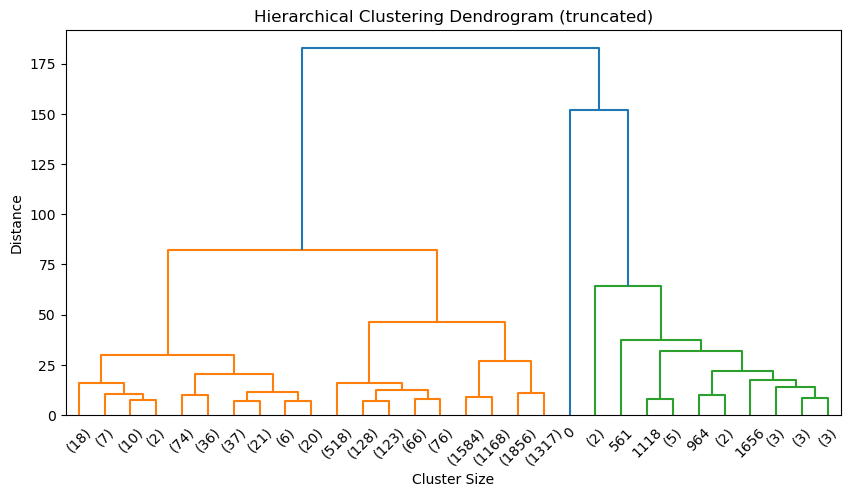

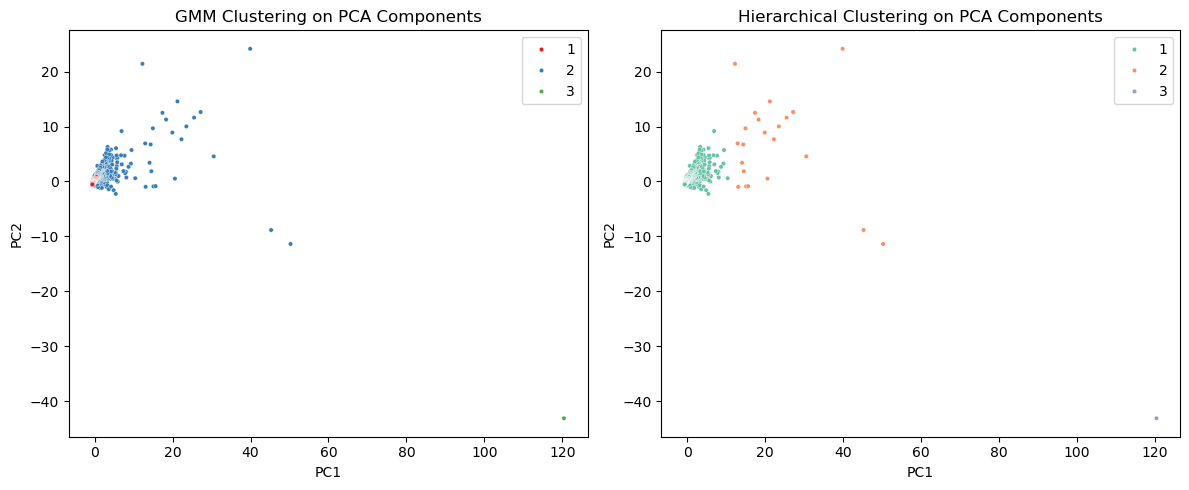

In [10]:
# Choose number of clusters = 3 based on previous analysis
best_n_clusters = 3

# Fit GMM with the chosen number of clusters.
gmm_final = GaussianMixture(n_components=best_n_clusters, random_state=42)
gmm_final.fit(X_pca)
labels_gmm = gmm_final.predict(X_pca) + 1 # usually indexed at zero, make it one for clarity
df_snapshot99['GMM_cluster'] = labels_gmm

# -----------------------------
# 4. Hierarchical Clustering
# -----------------------------
# Compute a linkage matrix using Ward's method.
linkage_matrix = sch.linkage(X_pca, method='ward')

# Plot the dendrogram to visually inspect the clustering structure.
plt.figure(figsize=(10, 5))
dendro = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

# Optionally, cut the dendrogram at a chosen number of clusters.
from scipy.cluster.hierarchy import fcluster
hier_labels = fcluster(linkage_matrix, t=best_n_clusters, criterion='maxclust')
df_snapshot99['Hier_cluster'] = hier_labels

# -----------------------------
# 5. Visualize the Clustering Results
# -----------------------------
# We can plot the PCA projection colored by the GMM and hierarchical clustering labels.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_gmm, palette="Set1", s=10)
plt.title("GMM Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hier_labels, palette="Set2", s=10)
plt.title("Hierarchical Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

It is difficult to see the different clusters from these plots and it looks like there are still only two. Let's check the number of data points in each cluster.

In [11]:
print("GMM Cluster Counts:")
print(df_snapshot99['GMM_cluster'].value_counts())

print("\nHierarchical Cluster Counts:")
print(df_snapshot99['Hier_cluster'].value_counts())

GMM Cluster Counts:
GMM_cluster
1    6009
2    1080
3       1
Name: count, dtype: int64

Hierarchical Cluster Counts:
Hier_cluster
1    7067
2      22
3       1
Name: count, dtype: int64


That makes sense, there is a single outlier in cluster three. My hypothesis would be that it is the most massive galaxy.

In [12]:
outlier_index = df_snapshot99[df_snapshot99['Hier_cluster'] == 3].index
print("Row index of galaxy in cluster 3 (hierarchical):", outlier_index.tolist()[0])

outlier_index = df_snapshot99[df_snapshot99['GMM_cluster'] == 3].index
print("Row index of galaxy in cluster 3 (GMM):", outlier_index.tolist()[0])

Row index of galaxy in cluster 3 (hierarchical): 0
Row index of galaxy in cluster 3 (GMM): 0


As expected it is the most massive galaxy that is the outlier. That makes sense, look at the magnitude of the data associated with it! That thing is a giant compared to all of the others.

In [13]:
# Visualize filtered dataset
print(df_snapshot99.head())

   stellar_mass     gas_mass       dm_mass       sfr    halfmass   bh_mass  \
0    368.292999  1559.956543  11360.775391  1.157833  362.230286  0.579029   
1     26.731363     0.005698    142.667740  0.000000   29.539518  0.054223   
2     13.025371     0.227375    143.777634  0.000985   58.699230  0.029711   
3      6.341208     0.004101     27.361473  0.000000   12.771269  0.020092   
4      6.088575     0.000337     12.617106  0.000000    5.421579  0.019615   

   GMM_cluster  Hier_cluster  
0            3             3  
1            2             1  
2            2             1  
3            2             1  
4            2             1  


## Outlier Analysis (Most Massive)

The outlier galaxy is certainly not a typical galaxy. According to GPT, in large cosmological simulations there is usually one most massive halo (a galaxy cluster) that contains thousands of smaller galaxies. The galaxy at the centre of that cluster (the central subhalo) is characterized by very high stellar mass, tons of hot gas, a huge dark matter halo, some residual star formation, and a very massive black hole. This central subhalo technically fits the simulation definition of a galaxy (i.e., it is identified by the SUBFIND algorithm), but it might be better described as the central dominant galaxy and omitted from the statistical analysis of the more reasonably sized galaxies. 

This outlier galaxy is interesting in its own right, but it is definitely skewing our clustering analysis. I am going to separate it from the snapshot 99 dataset and keep it on the side because it deserves analysis of its own, particularly how it evolved through time.

### Isolate the Outlier

In [14]:
# Step 1: Identify the row for the most massive galaxy
# (You already know it's row 0, but let's make it robust in case the order changes.)
max_stellar_idx = df_snapshot99['stellar_mass'].idxmax()

# Step 2: Extract it into its own dataframe
df_massive_outlier = df_snapshot99.loc[[max_stellar_idx]].copy()

# Step 3: Drop it from the main dataframe
df_snapshot99 = df_snapshot99.drop(index=max_stellar_idx).reset_index(drop=True)

### Clustering Without the Outlier

Original number of features: 6
Reduced number of features after PCA: 3
Explained variance ratio: [0.77245957 0.10246916 0.06581964]
GMM: n_clusters = 2, silhouette score = 0.548
GMM: n_clusters = 3, silhouette score = 0.527
GMM: n_clusters = 4, silhouette score = 0.167
GMM: n_clusters = 5, silhouette score = 0.085
GMM: n_clusters = 6, silhouette score = 0.074
GMM: n_clusters = 7, silhouette score = 0.074
GMM: n_clusters = 8, silhouette score = 0.038
GMM: n_clusters = 9, silhouette score = 0.038


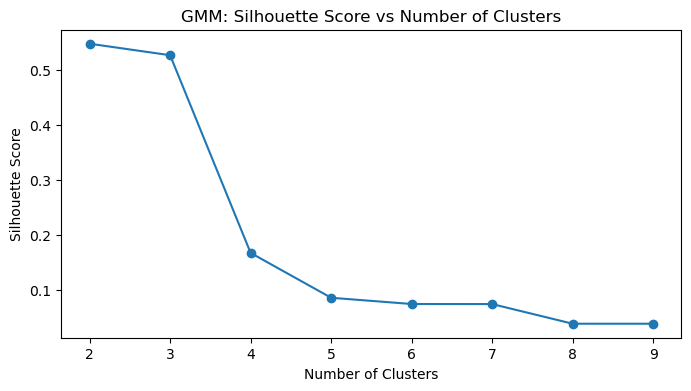

Best number of clusters for GMM based on silhouette score: 2


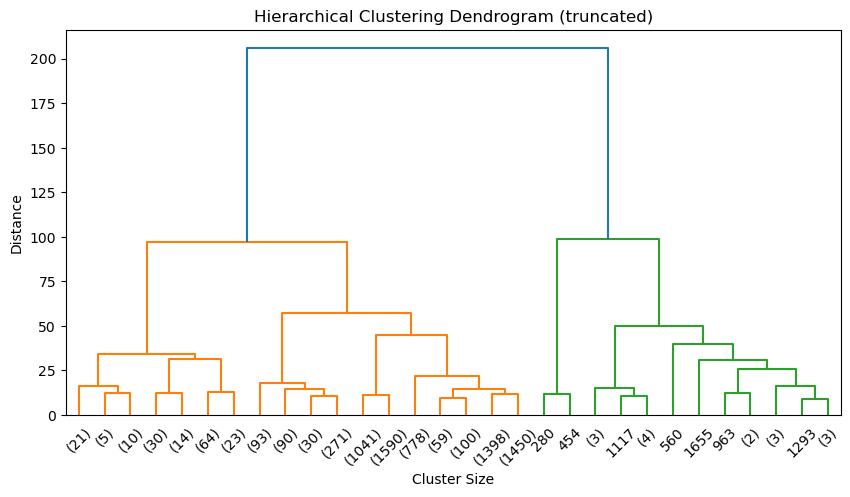

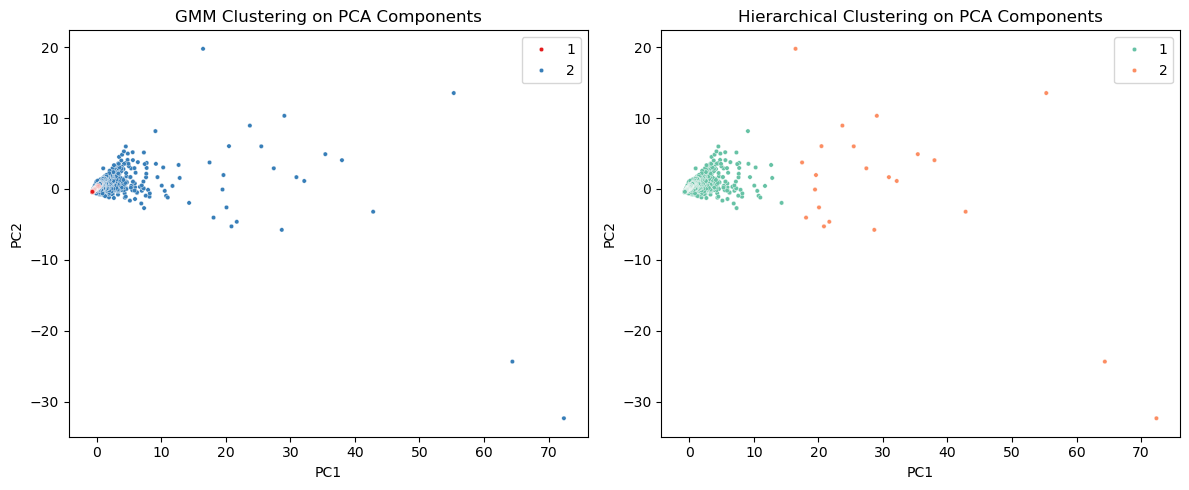

In [15]:
# -----------------------------
# 2. Data Preprocessing: Normalization and PCA
# -----------------------------
# Select the features you want to use in the clustering analysis.
# For example, let's use stellar_mass, gas_mass, dm_mass, sfr, halfmass, and bh_mass.
features = ['stellar_mass', 'gas_mass', 'dm_mass', 'sfr', 'halfmass', 'bh_mass']
X = df_snapshot99[features].values

# Normalize the data using StandardScaler.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce dimensionality.
# You can start with a PCA that preserves, say, 90% of the variance.
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)
print("Original number of features:", X.shape[1])
print("Reduced number of features after PCA:", X_pca.shape[1])
print("Explained variance ratio:", pca.explained_variance_ratio_)

# -----------------------------
# 3. Clustering Analysis using Gaussian Mixture Models (GMM)
# -----------------------------
# Let's try a range of cluster numbers and compute silhouette scores.
silhouette_scores = []
n_clusters_range = range(2, 10)
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_pca)
    labels = gmm.predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"GMM: n_clusters = {n_clusters}, silhouette score = {score:.3f}")

# Plot silhouette scores vs. number of clusters.
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("GMM: Silhouette Score vs Number of Clusters")
plt.show()

# Choose a number of clusters based on the silhouette score.
best_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
print("Best number of clusters for GMM based on silhouette score:", best_n_clusters)

# Fit GMM with the chosen number of clusters.
gmm_final = GaussianMixture(n_components=best_n_clusters, random_state=42)
gmm_final.fit(X_pca)
labels_gmm = gmm_final.predict(X_pca) + 1
df_snapshot99['GMM_cluster'] = labels_gmm

# -----------------------------
# 4. Hierarchical Clustering
# -----------------------------
# Compute a linkage matrix using Ward's method.
linkage_matrix = sch.linkage(X_pca, method='ward')

# Plot the dendrogram to visually inspect the clustering structure.
plt.figure(figsize=(10, 5))
dendro = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

# Optionally, cut the dendrogram at a chosen number of clusters.
from scipy.cluster.hierarchy import fcluster
hier_labels = fcluster(linkage_matrix, t=best_n_clusters, criterion='maxclust')
df_snapshot99['Hier_cluster'] = hier_labels

# -----------------------------
# 5. Visualize the Clustering Results
# -----------------------------
# We can plot the PCA projection colored by the GMM and hierarchical clustering labels.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_gmm, palette="Set1", s=10)
plt.title("GMM Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hier_labels, palette="Set2", s=10)
plt.title("Hierarchical Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

Again we see a competition between two and three clusters. It is possible that there are more outliers, this time I hypothesize that they are the lowest mass galaxies. Let's enforce three clusters again and check how many galaxies fall into each cluster.

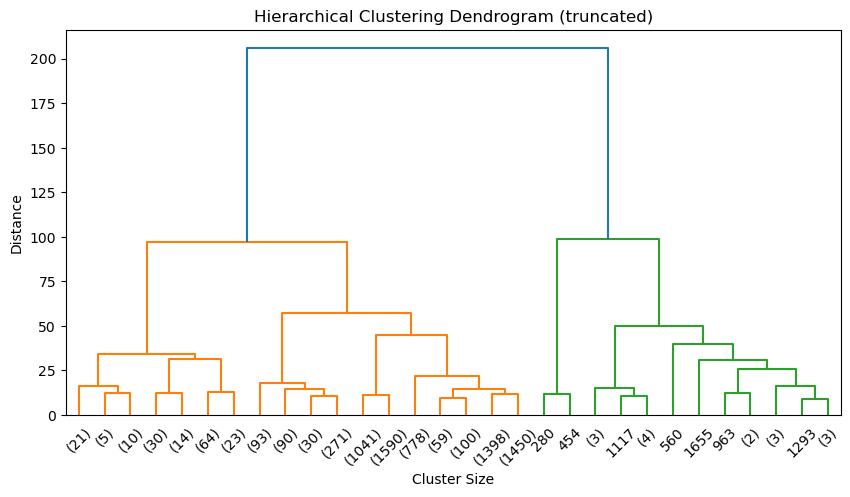

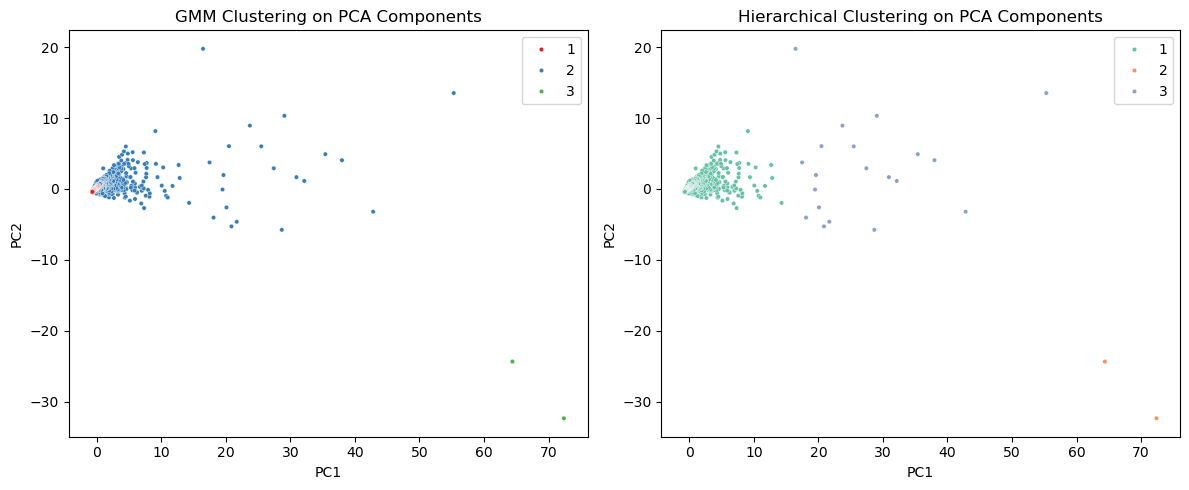

In [19]:
# Choose number of clusters = 3 based on previous analysis
best_n_clusters = 3

# Fit GMM with the chosen number of clusters.
gmm_final = GaussianMixture(n_components=best_n_clusters, random_state=42)
gmm_final.fit(X_pca)
labels_gmm = gmm_final.predict(X_pca) + 1 # usually indexed at zero, make it one for clarity
df_snapshot99['GMM_cluster'] = labels_gmm

# -----------------------------
# 4. Hierarchical Clustering
# -----------------------------
# Compute a linkage matrix using Ward's method.
linkage_matrix = sch.linkage(X_pca, method='ward')

# Plot the dendrogram to visually inspect the clustering structure.
plt.figure(figsize=(10, 5))
dendro = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

# Optionally, cut the dendrogram at a chosen number of clusters.
from scipy.cluster.hierarchy import fcluster
hier_labels = fcluster(linkage_matrix, t=best_n_clusters, criterion='maxclust')
df_snapshot99['Hier_cluster'] = hier_labels

# -----------------------------
# 5. Visualize the Clustering Results
# -----------------------------
# We can plot the PCA projection colored by the GMM and hierarchical clustering labels.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_gmm, palette="Set1", s=10)
plt.title("GMM Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hier_labels, palette="Set2", s=10)
plt.title("Hierarchical Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

In [20]:
print("GMM Cluster Counts:")
print(df_snapshot99['GMM_cluster'].value_counts())

print("\nHierarchical Cluster Counts:")
print(df_snapshot99['Hier_cluster'].value_counts())

GMM Cluster Counts:
GMM_cluster
1    5580
2    1507
3       2
Name: count, dtype: int64

Hierarchical Cluster Counts:
Hier_cluster
1    7067
3      20
2       2
Name: count, dtype: int64


In [23]:
outlier_index = df_snapshot99[df_snapshot99['Hier_cluster'] == 2].index
print("Row indices of galaxies in cluster 2 (hierarchical):", outlier_index.tolist())

outlier_index = df_snapshot99[df_snapshot99['GMM_cluster'] == 3].index
print("Row indices of galaxies in cluster 3 (GMM):", outlier_index.tolist())

Row indices of galaxies in cluster 2 (hierarchical): [280, 454]
Row indices of galaxies in cluster 3 (GMM): [280, 454]


Interestingly, these are not the two lowest mass galaxies. I wonder why their PCA components are so different from the others.

## Outlier Analysis (Extreme PCs)

The hypothesis that the two outliers were the galaxies with the smallest mass was incorrect. In fact, the galaxies at row IDs [280, 454] are quite massive relative to the other 7090 galaxies in the dataset. However, compared to all of the other galaxies in the dataset, these two have notably extreme PC1 and PC2 values. It would be interesting to figure out why this is the case, i.e., what are the key properties of these two galaxies that differentiate them from all of the other high-mass galaxies?

### Compare Outlier Properties to the Rest of the Data

In [24]:
# Compare each outlier's property to the median of that property
median_values = df_snapshot99.median(numeric_only=True)  # numeric_only=True if using recent pandas
diff_from_median = outliers[median_values.index] - median_values
print(diff_from_median)

NameError: name 'outliers' is not defined

Unfortunately, up until now I have been assuming that the galaxies are ordered according to their stellar mass, however based on the previous print statements that is clearly not the case. In fact, it looks like row IDs 280 and 454 are actually the second two most massive galaxies. This essentially marks the end of the investigation into clustering of the most massive galaxies at z = 0, since I do not think that we are discovering anything useful through this analysis other than the fact that the most massive galaxies will tend to have extreme PC values. It seems to me that we need a more representative sample of galaxies in order to identify useful information from the clustering approach.

However, I will say that I have realized that the properties we are observing are far too correlated to be a useful way of classifying galaxies. Pretty much all of the metrics we are observing (stellar_mass    gas_mass      dm_mass       sfr    halfmass   bh_mass) are highly correlated to the total mass of the galaxy. We should really be evaluating additional properties that are not strongly correlated with the mass if we want to be able to do anything physically relevant, since we know that galaxies cannot be classified by their total mass alone (i.e., there are elliptical, spiral, and irregular galaxies with masses across the entire spectrum).

## Analyzing the PCA

In [25]:
import numpy as np

# Suppose you have:
# features = ['stellar_mass', 'gas_mass', 'dm_mass', 'sfr', 'halfmass', 'bh_mass']
# And you ran:
# pca = PCA(n_components=0.90)
# X_pca = pca.fit_transform(X_scaled)

print("PCA components shape:", pca.components_.shape)
print("Features:", features)

for i, component in enumerate(pca.components_):
    print(f"\nPrincipal Component {i+1}:")
    for feat, weight in zip(features, component):
        print(f"  {feat:12s} => {weight: .4f}")

PCA components shape: (3, 6)
Features: ['stellar_mass', 'gas_mass', 'dm_mass', 'sfr', 'halfmass', 'bh_mass']

Principal Component 1:
  stellar_mass =>  0.4471
  gas_mass     =>  0.4157
  dm_mass      =>  0.4442
  sfr          =>  0.3361
  halfmass     =>  0.3713
  bh_mass      =>  0.4231

Principal Component 2:
  stellar_mass => -0.1133
  gas_mass     => -0.3940
  dm_mass      => -0.2877
  sfr          =>  0.7662
  halfmass     =>  0.3799
  bh_mass      => -0.1332

Principal Component 3:
  stellar_mass => -0.0436
  gas_mass     => -0.2535
  dm_mass      => -0.0846
  sfr          => -0.5388
  halfmass     =>  0.7887
  bh_mass      =>  0.1198


# Clustering for Classification at z = 99 Using a Broader Collection of Galaxy Properties

The previous analysis resulted in the realiztion that the chosen subhalo properties were insufficient for classifying galaxies by morphology. Additionally, the data frame was not ordered as expected, leading to a poor understanding of the correlation between the PCs and the true subhalo properties. In this section, we will repeat a similar analysis as was performed previously, but with the addition of many physics-informed features that will help us classify based on morphology. Additionally, the data will be immediately ordered according to stellar mass and the most massive galaxy that was previously removed from the analysis will be readded to the data frame. 

If it turns out that the clusters we come up with do not correspond to the visual morphology of the galaxies, this is strong evidence for a new classification system to be adopted in cosmology. Galaxy classification is widely used in astronomy to infer how galaxies evolve over time among other trends. If we decide that the classical visual morphology classification is not optimal, this could inform future research into galaxy evolution and call into question the results of previous work that utilized visual morphology as the primary classification tool.

## Examine All Fields and Choose a Subset

Available fields in subhalo catalog: ['count', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'SubhaloStarMetallicityHalfRad', 'SubhaloStarMetallicityMaxRad', 'SubhaloStellarPhotometrics', 'SubhaloStellarPhotometricsMassInRad', 'SubhaloStellarPhotometricsRad', 'SubhaloVel', 'SubhaloVelDisp', 'SubhaloVmax', 'SubhaloVmaxRad', 'SubhaloWindMass']

We do not want to load all of these fields because 1) they are not all useful for classification and 2) loading all of them will use significant data storage. Based on my research, the properties that will be most useful for classification are: 1) Mass and Structural Properties, 2) Star Formation & Gas Properties, 3) Black Hole & Feedback, 4)Kinematic & Dynamical Properties, 5) Photometry & Color Information, and 6) Metallicity Properties. 

In [26]:
# Run this in case kernel resets
import illustris_python as il
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For scaling, PCA, and clustering:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

In [27]:
# Set the base path for your TNG50-1 dataset
basePath = '../sims.TNG/TNG50-1/output/' 
snap = 99

fields = ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloFlag', 'SubhaloGasMetalFractionsHalfRad',  'SubhaloHalfmassRad', 'SubhaloMassInHalfRad', 'SubhaloMassType', 
          'SubhaloSFRinHalfRad', 'SubhaloSpin', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetallicityHalfRad', 'SubhaloStellarPhotometrics', 'SubhaloVelDisp', 
          'SubhaloVmax']

subhalos_broadfield = il.groupcat.loadSubhalos(basePath, snap, fields = fields)

In [28]:
data_broadfield = {}
for field in fields:
    # If the field exists in your subhalos_broadfield dictionary, add it.
    if field in subhalos_broadfield:
        data_broadfield[field] = subhalos_broadfield[field]
    else:
        print(f"Field {field} not found in the subhalo dataset.")

# Mass types
stellar_mass_broadfield = data_broadfield['SubhaloMassType'][:, 4]
gas_mass_broadfield = data_broadfield['SubhaloMassType'][:, 0]
dm_mass_broadfield = data_broadfield['SubhaloMassType'][:, 1]

# Colours
mag_u_broadfield = data_broadfield['SubhaloStellarPhotometrics'][:, 0]
mag_r_broadfield = data_broadfield['SubhaloStellarPhotometrics'][:, 5]

# Spins in each dimension
spin_x_broadfield = data_broadfield['SubhaloSpin'][:, 0]
spin_y_broadfield = data_broadfield['SubhaloSpin'][:, 1]
spin_z_broadfield = data_broadfield['SubhaloSpin'][:, 2]

# Gas metal abundances
H_gas_abundance_broadfield = data_broadfield['SubhaloGasMetalFractionsHalfRad'][:, 0]
He_gas_abundance_broadfield = data_broadfield['SubhaloGasMetalFractionsHalfRad'][:, 1]
C_gas_abundance_broadfield = data_broadfield['SubhaloGasMetalFractionsHalfRad'][:, 2]
N_gas_abundance_broadfield = data_broadfield['SubhaloGasMetalFractionsHalfRad'][:, 3]
O_gas_abundance_broadfield = data_broadfield['SubhaloGasMetalFractionsHalfRad'][:, 4]
Ne_gas_abundance_broadfield = data_broadfield['SubhaloGasMetalFractionsHalfRad'][:, 5]
Mg_gas_abundance_broadfield = data_broadfield['SubhaloGasMetalFractionsHalfRad'][:, 6]
Si_gas_abundance_broadfield = data_broadfield['SubhaloGasMetalFractionsHalfRad'][:, 7]
Fe_gas_abundance_broadfield = data_broadfield['SubhaloGasMetalFractionsHalfRad'][:, 8]

# Star metal abundances
H_metal_abundance_broadfield = data_broadfield['SubhaloStarMetalFractionsHalfRad'][:, 0]
He_metal_abundance_broadfield = data_broadfield['SubhaloStarMetalFractionsHalfRad'][:, 1]
C_metal_abundance_broadfield = data_broadfield['SubhaloStarMetalFractionsHalfRad'][:, 2]
N_metal_abundance_broadfield = data_broadfield['SubhaloStarMetalFractionsHalfRad'][:, 3]
O_metal_abundance_broadfield = data_broadfield['SubhaloStarMetalFractionsHalfRad'][:, 4]
Ne_metal_abundance_broadfield = data_broadfield['SubhaloStarMetalFractionsHalfRad'][:, 5]
Mg_metal_abundance_broadfield = data_broadfield['SubhaloStarMetalFractionsHalfRad'][:, 6]
Si_metal_abundance_broadfield = data_broadfield['SubhaloStarMetalFractionsHalfRad'][:, 7]
Fe_metal_abundance_broadfield = data_broadfield['SubhaloStarMetalFractionsHalfRad'][:, 8]


df_broadfield = pd.DataFrame({
    'bh_mass': data_broadfield['SubhaloBHMass'],
    'bh_mdot': data_broadfield['SubhaloBHMdot'],
    'flags': data_broadfield['SubhaloFlag'],
    'H_gas_abundance': H_gas_abundance_broadfield,
    'He_gas_abundance': He_gas_abundance_broadfield,
    'C_gas_abundance': C_gas_abundance_broadfield,
    'N_gas_abundance': N_gas_abundance_broadfield,
    'O_gas_abundance': O_gas_abundance_broadfield,
    'Ne_gas_abundance': Ne_gas_abundance_broadfield,
    'Mg_gas_abundance': Mg_gas_abundance_broadfield,
    'Si_gas_abundance': Si_gas_abundance_broadfield,
    'Fe_gas_abundance': Fe_gas_abundance_broadfield,
    'H_metal_abundance': H_metal_abundance_broadfield,
    'He_metal_abundance': He_metal_abundance_broadfield,
    'C_metal_abundance': C_metal_abundance_broadfield,
    'N_metal_abundance': N_metal_abundance_broadfield,
    'O_metal_abundance': O_metal_abundance_broadfield,
    'Ne_metal_abundance': Ne_metal_abundance_broadfield,
    'Mg_metal_abundance': Mg_metal_abundance_broadfield,
    'Si_metal_abundance': Si_metal_abundance_broadfield,
    'Fe_metal_abundance': Fe_metal_abundance_broadfield,
    'half_mass_radius': data_broadfield['SubhaloHalfmassRad'],
    'mass_HR': data_broadfield['SubhaloMassInHalfRad'],
    'stellar_mass': stellar_mass_broadfield,
    'gas_mass': gas_mass_broadfield,
    'dm_mass': dm_mass_broadfield,
    'sfr_HR': data_broadfield['SubhaloSFRinHalfRad'],
    'spin_x': spin_x_broadfield,
    'spin_y': spin_y_broadfield,
    'spin_z': spin_z_broadfield,
    'star_metallicity_HR': data_broadfield['SubhaloStarMetallicityHalfRad'],
    'mag_u': mag_u_broadfield,
    'mag_r': mag_r_broadfield,
    'velocity_dispersion': data_broadfield['SubhaloVelDisp'],
    'velocity_maximum': data_broadfield['SubhaloVmax']
})

In [29]:
# Total number of columns in the DataFrame
total_rows = len(df_broadfield)

# Total number of rows where 'flags' is False
flagged_rows = len(df_broadfield[df_broadfield['flags'] == False])

# Print the results
print(f"Total number of rows: {total_rows}")
print(f"Total number of flagged rows (where 'flags' is False): {flagged_rows}")

# Omit flagged data from dataframe and then drop flags column
df_broadfield = df_broadfield[df_broadfield['flags'] == True]
df_broadfield = df_broadfield.drop(columns=['flags'])

Total number of rows: 5688113
Total number of flagged rows (where 'flags' is False): 1349


In [30]:
# Drop rows where 'stellar_mass' is lower than 0.01 (10^8 solar masses)
df_broadfield = df_broadfield[df_broadfield['stellar_mass'] >= 0.01]

In [31]:
print(len(df_broadfield))

7090


In [32]:
# Order the dataframe by stellar mass (largest first)
df_broadfield = df_broadfield.sort_values(by='stellar_mass', ascending=False).reset_index(drop=True)

## Data Standardization, Correlation Matrix, and PCA Analysis

In [34]:
# Extract the feature matrix.
X = df_broadfield.values

# Standardize the features (mean=0, variance=1).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

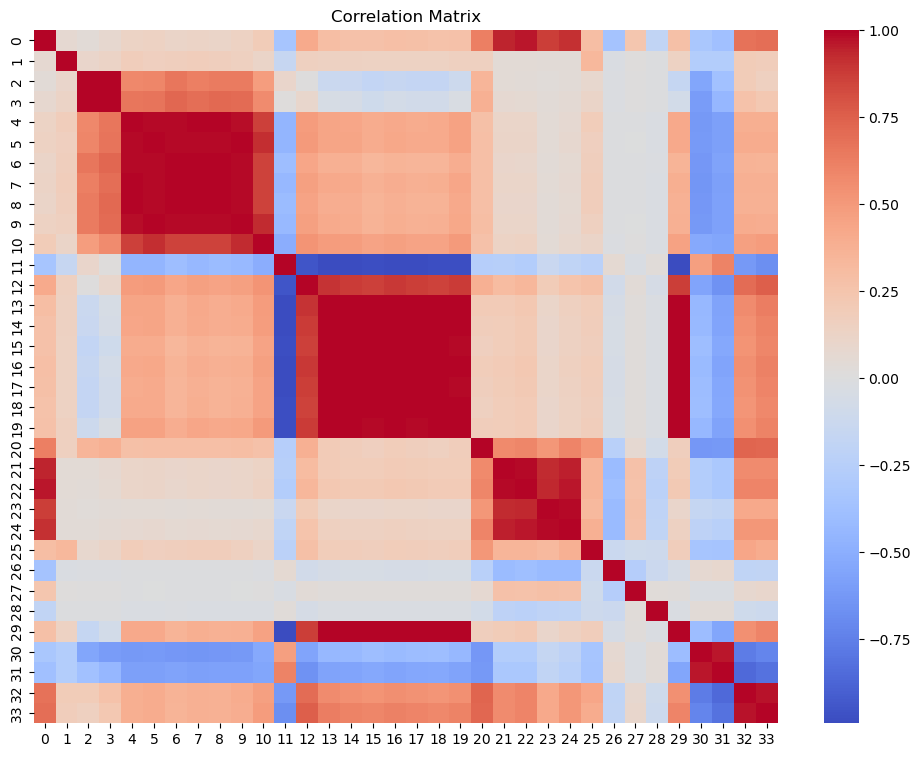

In [35]:
# Compute a correlation matrix for the (scaled) features.
corr_matrix = pd.DataFrame(X_scaled).corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Correlation matrix is interesting as it shows that the metal and gas abundances are highly correlated and it may be reasonable to only use one tracer to represent all of the metal abundances. There is definitely other interesting information in here, but it is too much to unpack right now.

In [36]:
# Perform PCA on the scaled features.
pca = PCA(n_components=0.90)  # Retain 90% of the variance.
X_pca = pca.fit_transform(X_scaled)
print("Number of principal components retained:", X_pca.shape[1])
print("Explained variance ratios:", pca.explained_variance_ratio_)

# Display PCA loadings to interpret which original features are most important.
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
print("\nPCA Loadings:")
print(loadings)

Number of principal components retained: 7
Explained variance ratios: [0.43954256 0.17720716 0.16133271 0.0513158  0.03525009 0.03103573
 0.02574671]

PCA Loadings:
         PC1       PC2       PC3       PC4       PC5       PC6       PC7
0  -0.126834 -0.136452  0.316786  0.100792 -0.046542 -0.071103 -0.025501
1  -0.058960  0.026274  0.015868 -0.275149  0.020133  0.721874  0.370690
2  -0.066469  0.328077  0.113226 -0.070098  0.081164 -0.114931  0.068866
3  -0.090521  0.327691  0.104056 -0.063300  0.073204 -0.107794  0.060803
4  -0.191628  0.249785 -0.026710  0.138462 -0.054856  0.084888 -0.040415
5  -0.193093  0.250221 -0.025712  0.147158 -0.051163  0.055071 -0.042957
6  -0.182048  0.274383 -0.013930  0.130119 -0.045164  0.066666 -0.030242
7  -0.188260  0.261080 -0.020418  0.130318 -0.049278  0.076764 -0.033701
8  -0.185183  0.268069 -0.016929  0.130428 -0.047425  0.071544 -0.032147
9  -0.187790  0.264301 -0.017413  0.139501 -0.043488  0.034391 -0.035678
10 -0.191356  0.197059 -0.031565

It is pretty difficult to interpret what each of these columns means based on this matrix.

## Initial GMM and Hierarchical Models

GMM with 2 clusters: Silhouette Score = 0.399
GMM with 3 clusters: Silhouette Score = 0.402
GMM with 4 clusters: Silhouette Score = 0.423
GMM with 5 clusters: Silhouette Score = 0.389
GMM with 6 clusters: Silhouette Score = 0.247
GMM with 7 clusters: Silhouette Score = 0.125
GMM with 8 clusters: Silhouette Score = 0.128
GMM with 9 clusters: Silhouette Score = 0.112
GMM with 10 clusters: Silhouette Score = 0.088


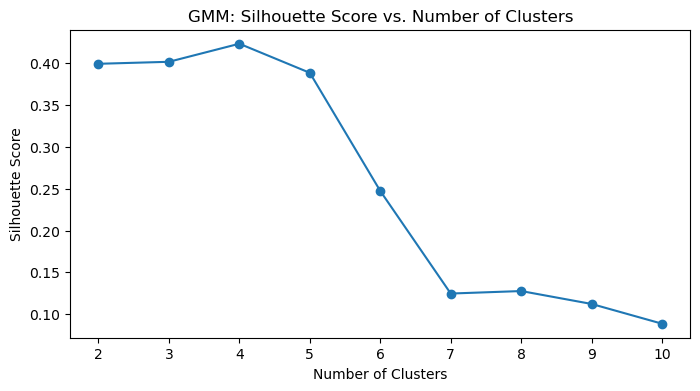

Optimal number of clusters according to GMM: 4


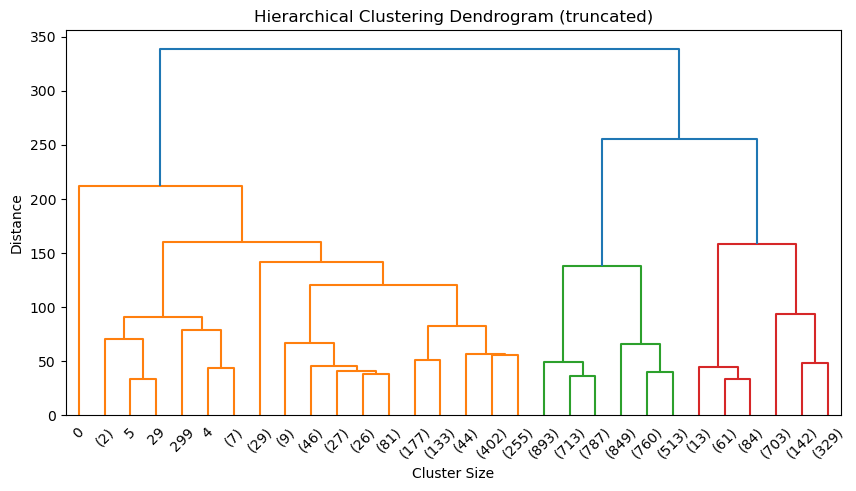

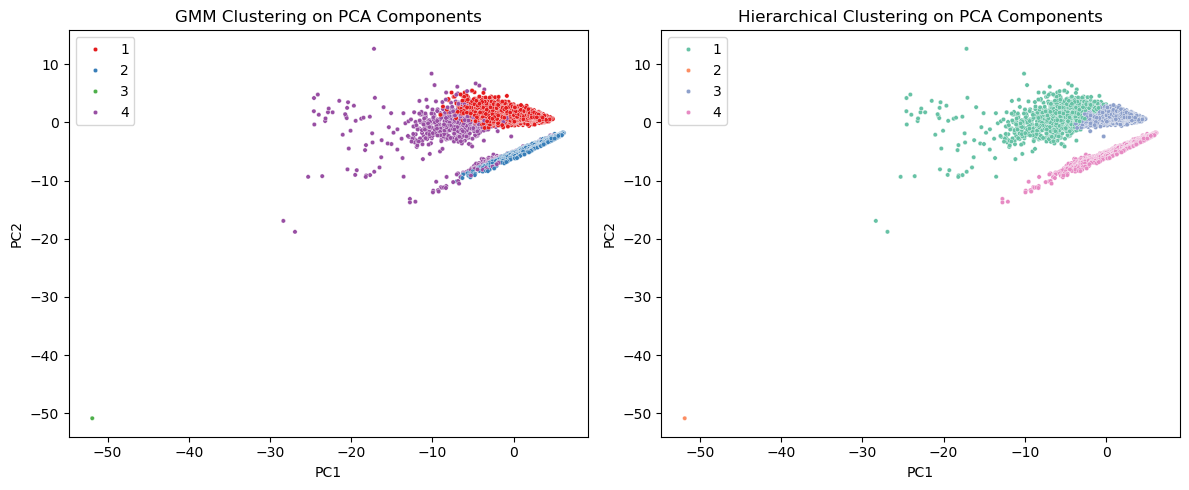

In [123]:
# -----------------------------
# 4. Clustering Algorithms: GMM and Hierarchical Clustering
# -----------------------------

# --- Gaussian Mixture Models (GMM) ---
silhouette_scores = []
cluster_range = range(2, 11)
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_pca)
    labels = gmm.predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"GMM with {n_clusters} clusters: Silhouette Score = {score:.3f}")

plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("GMM: Silhouette Score vs. Number of Clusters")
plt.show()

# Choose the best number of clusters (e.g., based on the highest silhouette score)
best_n_clusters = cluster_range[np.argmax(silhouette_scores)]
print("Optimal number of clusters according to GMM:", best_n_clusters)

# Fit final GMM model.
gmm_final = GaussianMixture(n_components=best_n_clusters, random_state=42)
gmm_final.fit(X_pca)
labels_gmm = gmm_final.predict(X_pca) + 1
df_broadfield['GMM_cluster'] = labels_gmm

# --- Hierarchical Clustering ---
linkage_matrix = sch.linkage(X_pca, method='ward')

plt.figure(figsize=(10, 5))
dendro = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

# For hierarchical clustering, either specify the number of clusters directly...
hier_labels = fcluster(linkage_matrix, t=best_n_clusters, criterion='maxclust')
df_broadfield['Hier_cluster'] = hier_labels

# ...or, if you prefer, choose a distance threshold (adjust as needed).
# hier_labels_dist = fcluster(linkage_matrix, t=20, criterion='distance')
# df_all['Hier_cluster_dist'] = hier_labels_dist

# -----------------------------
# 5. Visualizing the Clusters in PCA Space
# -----------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_gmm, palette="Set1", s=10)
plt.title("GMM Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hier_labels, palette="Set2", s=10)
plt.title("Hierarchical Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

## Outlier Analysis (Most Massive)

Again, I think it is very reasonable to omit that super-massive galaxy that is in the bottom left of the map as it is clearly a significant outlier.

### Isolate and Drop the Outlier

In [124]:
# If you're using Hierarchical Clustering and want to find the galaxy in cluster 3:
outlier_index = df_broadfield[df_broadfield['GMM_cluster'] == 3].index
print("Row index of galaxy in cluster 3 (GMM):", outlier_index.tolist())

Row index of galaxy in cluster 3 (GMM): [0]


In [125]:
# Identify the row for the most massive galaxy
# (You already know it's row 0, but let's make it robust in case the order changes.)
max_stellar_idx = df_broadfield['stellar_mass'].idxmax()

# Drop it from the main dataframe
df_broadfield = df_broadfield.drop(index=max_stellar_idx).reset_index(drop=True)

### Recompute Scaling and PCA

In [127]:
# Extract the feature matrix.
X = df_broadfield.values

# Standardize the features (mean=0, variance=1).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [128]:
# Perform PCA on the scaled features.
pca = PCA(n_components=0.90)  # Retain 90% of the variance.
X_pca = pca.fit_transform(X_scaled)
print("Number of principal components retained:", X_pca.shape[1])
print("Explained variance ratios:", pca.explained_variance_ratio_)

# Display PCA loadings to interpret which original features are most important.
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

Number of principal components retained: 7
Explained variance ratios: [0.45000324 0.17634731 0.14422825 0.04189548 0.03614331 0.03014725
 0.02543513]


### Clustering Without Outlier

GMM with 2 clusters: Silhouette Score = 0.463
GMM with 3 clusters: Silhouette Score = 0.156
GMM with 4 clusters: Silhouette Score = 0.345
GMM with 5 clusters: Silhouette Score = 0.220
GMM with 6 clusters: Silhouette Score = 0.218
GMM with 7 clusters: Silhouette Score = 0.178
GMM with 8 clusters: Silhouette Score = 0.146
GMM with 9 clusters: Silhouette Score = 0.146
GMM with 10 clusters: Silhouette Score = 0.104


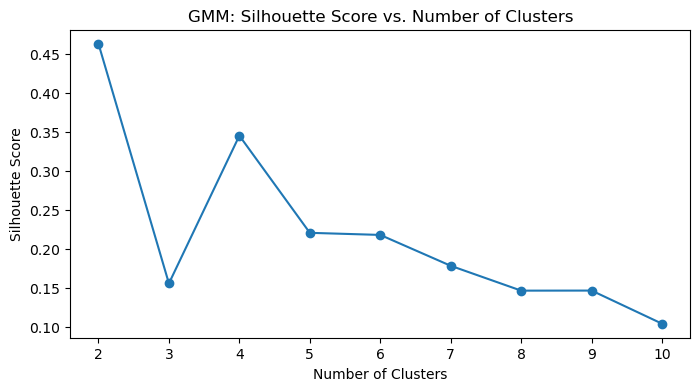

Optimal number of clusters according to GMM: 2


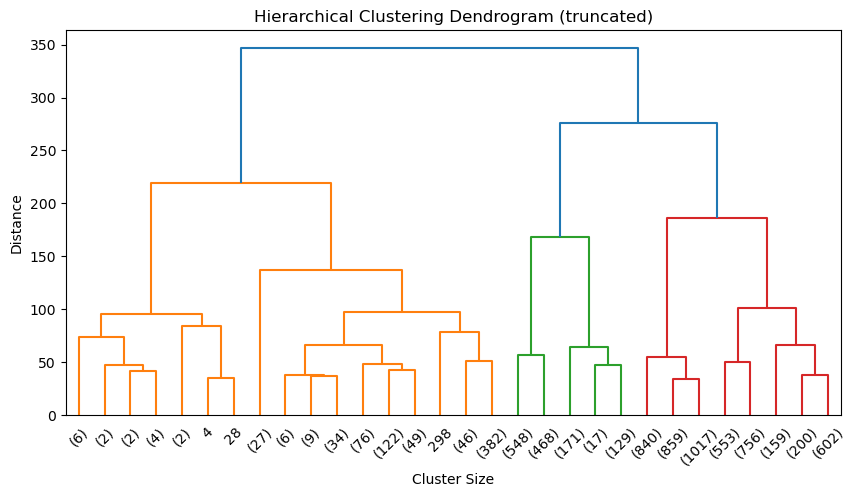

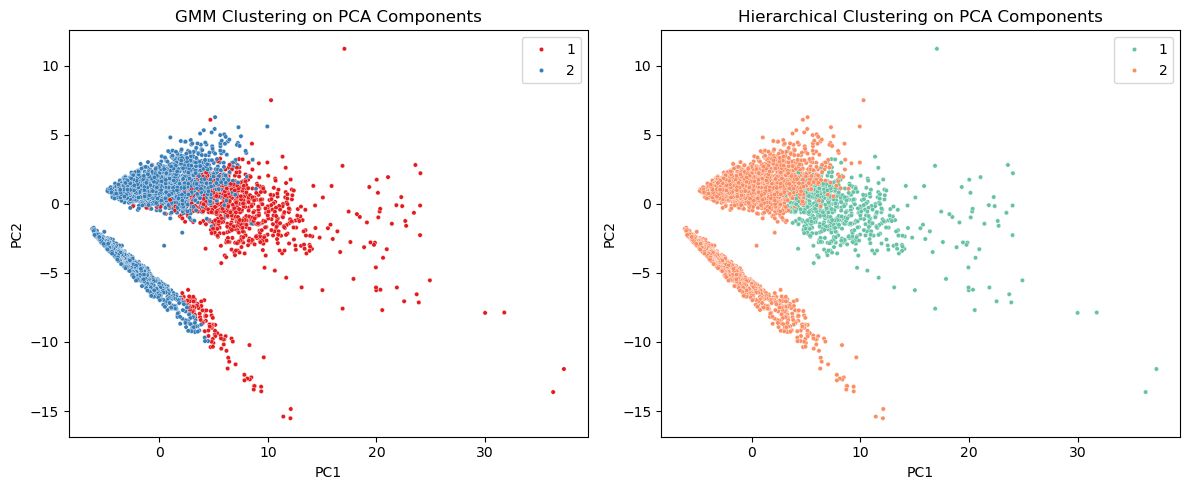

In [130]:
# -----------------------------
# 4. Clustering Algorithms: GMM and Hierarchical Clustering
# -----------------------------

# --- Gaussian Mixture Models (GMM) ---
silhouette_scores = []
cluster_range = range(2, 11)
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_pca)
    labels = gmm.predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"GMM with {n_clusters} clusters: Silhouette Score = {score:.3f}")

plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("GMM: Silhouette Score vs. Number of Clusters")
plt.show()

# Choose the best number of clusters (e.g., based on the highest silhouette score)
best_n_clusters = cluster_range[np.argmax(silhouette_scores)]
print("Optimal number of clusters according to GMM:", best_n_clusters)

# Fit final GMM model.
gmm_final = GaussianMixture(n_components=best_n_clusters, random_state=42)
gmm_final.fit(X_pca)
labels_gmm = gmm_final.predict(X_pca) + 1
df_broadfield['GMM_cluster'] = labels_gmm

# --- Hierarchical Clustering ---
linkage_matrix = sch.linkage(X_pca, method='ward')

plt.figure(figsize=(10, 5))
dendro = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

# For hierarchical clustering, either specify the number of clusters directly...
hier_labels = fcluster(linkage_matrix, t=best_n_clusters, criterion='maxclust')
df_broadfield['Hier_cluster'] = hier_labels

# ...or, if you prefer, choose a distance threshold (adjust as needed).
# hier_labels_dist = fcluster(linkage_matrix, t=20, criterion='distance')
# df_all['Hier_cluster_dist'] = hier_labels_dist

# -----------------------------
# 5. Visualizing the Clusters in PCA Space
# -----------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_gmm, palette="Set1", s=10)
plt.title("GMM Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hier_labels, palette="Set2", s=10)
plt.title("Hierarchical Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

The GMM algorithm has a clear preference for two clusters (based on the silhouette score), while the hierarchical model seems to prefer four clusters. The silhouette score for four clusters is worse, but not terrible, and quantitatively it seems to me that there are more than two clusters here. Let's see what happens if we enforce four clusters.

### Enforcing Four Clusters

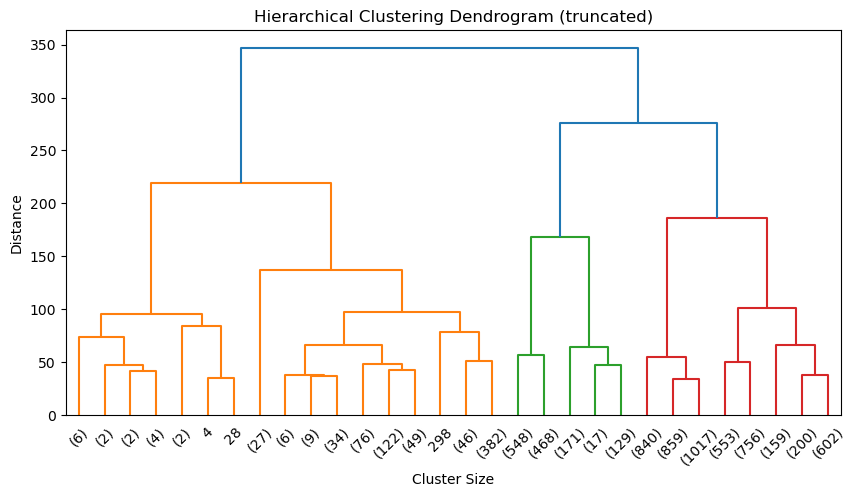

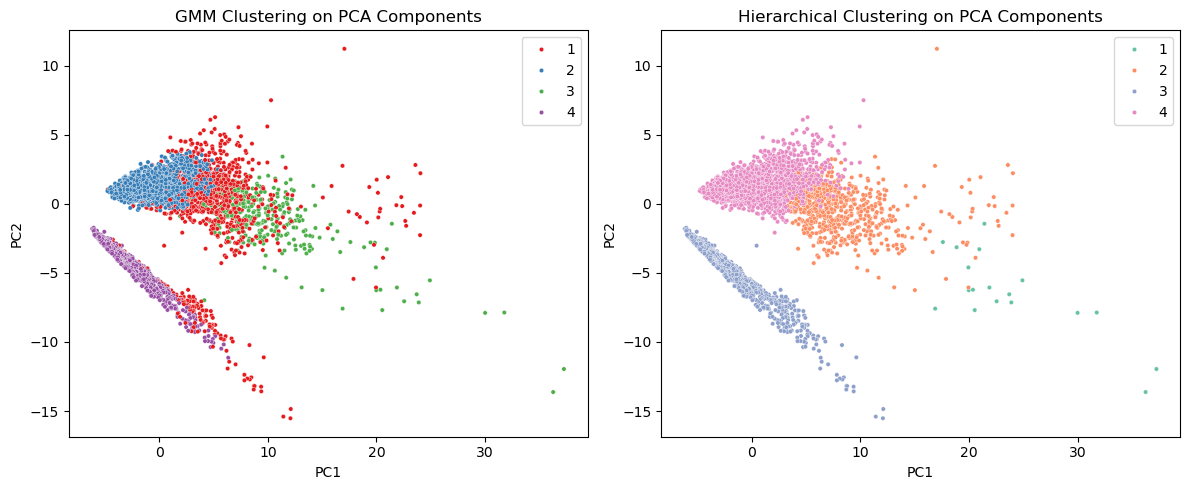

In [131]:
# Choose the best number of clusters (e.g., based on the highest silhouette score)
best_n_clusters = 4

# Fit final GMM model.
gmm_final = GaussianMixture(n_components=best_n_clusters, random_state=42)
gmm_final.fit(X_pca)
labels_gmm = gmm_final.predict(X_pca) + 1
df_broadfield['GMM_cluster'] = labels_gmm

# --- Hierarchical Clustering ---
linkage_matrix = sch.linkage(X_pca, method='ward')

plt.figure(figsize=(10, 5))
dendro = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

# For hierarchical clustering, either specify the number of clusters directly...
hier_labels = fcluster(linkage_matrix, t=best_n_clusters, criterion='maxclust')
df_broadfield['Hier_cluster'] = hier_labels

# ...or, if you prefer, choose a distance threshold (adjust as needed).
# hier_labels_dist = fcluster(linkage_matrix, t=20, criterion='distance')
# df_all['Hier_cluster_dist'] = hier_labels_dist

# -----------------------------
# 5. Visualizing the Clusters in PCA Space
# -----------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_gmm, palette="Set1", s=10)
plt.title("GMM Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hier_labels, palette="Set2", s=10)
plt.title("Hierarchical Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

Interesting, I am not sure that I agree with the choice of clusters particularly the mixture of red and purple in the bottom left of the GMM. This indicates to me that there is interesting behaviour in the other components of the PCA (recall that there are seven PCs in this analysis).

## Working with the Time Series Data

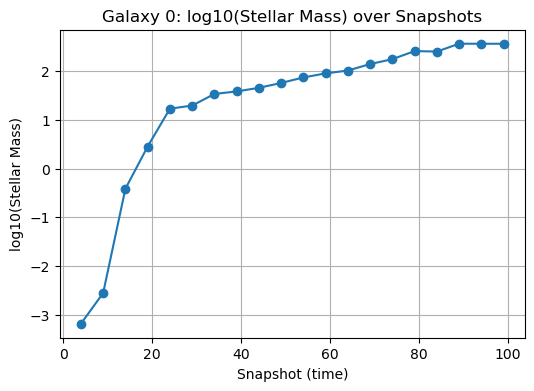

In [11]:
# 1. Filter the DataFrame to keep only galaxy_id == 1
gal1_data = df_timeseries[df_timeseries["galaxy_id"] ==0]

# 2. Compute the log (base-10) of the stellar mass
log_stellar_mass = np.log10(gal1_data["stellar_mass"])

# 3. Plot log(stellar_mass) vs. snapshot
plt.figure(figsize=(6, 4))
plt.plot(gal1_data["snapshot"], log_stellar_mass, marker='o')
plt.xlabel("Snapshot (time)")
plt.ylabel("log10(Stellar Mass)")
plt.title("Galaxy 0: log10(Stellar Mass) over Snapshots")
plt.grid(True)
plt.show()

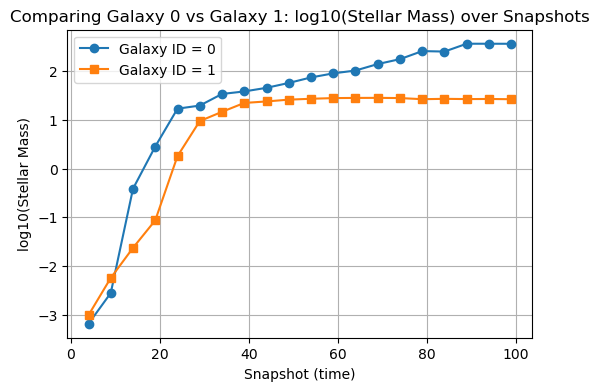

In [12]:
# Filter the DataFrame for galaxy_id = 0 and galaxy_id = 1
gal0_data = df_timeseries[df_timeseries["galaxy_id"] == 0]
gal1_data = df_timeseries[df_timeseries["galaxy_id"] == 1]

# Compute the log10(stellar_mass) for each galaxy
log_stellar_mass_gal0 = np.log10(gal0_data["stellar_mass"])
log_stellar_mass_gal1 = np.log10(gal1_data["stellar_mass"])

# Plot on the same figure
plt.figure(figsize=(6,4))

plt.plot(gal0_data["snapshot"], log_stellar_mass_gal0, 
         marker='o', label="Galaxy ID = 0")
plt.plot(gal1_data["snapshot"], log_stellar_mass_gal1, 
         marker='s', label="Galaxy ID = 1")

plt.xlabel("Snapshot (time)")
plt.ylabel("log10(Stellar Mass)")
plt.title("Comparing Galaxy 0 vs Galaxy 1: log10(Stellar Mass) over Snapshots")
plt.legend()
plt.grid(True)
plt.show()

/home/tnguser/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


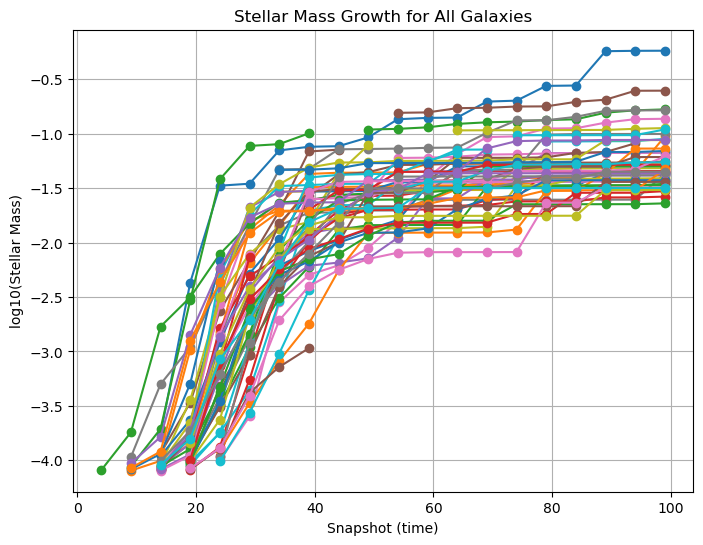

In [13]:
# Get the unique galaxy IDs
unique_galaxy_ids = df_timeseries["galaxy_id"].unique()

plt.figure(figsize=(8, 6))

for gid in unique_galaxy_ids:
    # Filter rows for this galaxy ID
    gal_data = df_timeseries[df_timeseries["galaxy_id"] == gid].copy()
    
    # (Optional) sort by snapshot, in case it's not already sorted
    gal_data.sort_values(by="snapshot", inplace=True)
    
    # Compute log10(stellar_mass)
    log_stellar_mass = np.log10(gal_data["bh_mass"])
    
    # Plot snapshot vs. log10(stellar_mass)
    plt.plot(gal_data["snapshot"], log_stellar_mass, marker='o', label=f"Galaxy {gid}")

plt.xlabel("Snapshot (time)")
plt.ylabel("log10(Stellar Mass)")
plt.title("Stellar Mass Growth for All Galaxies")
# plt.legend()
plt.grid(True)
plt.show()


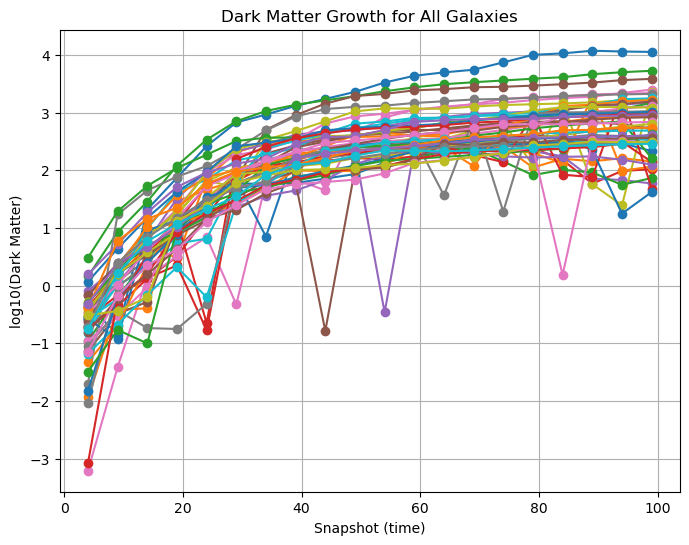

In [14]:
# Get the unique galaxy IDs
unique_galaxy_ids = df_timeseries["galaxy_id"].unique()

plt.figure(figsize=(8, 6))

for gid in unique_galaxy_ids:
    # Filter rows for this galaxy ID
    gal_data = df_timeseries[df_timeseries["galaxy_id"] == gid].copy()
    
    # (Optional) sort by snapshot, in case it's not already sorted
    gal_data.sort_values(by="snapshot", inplace=True)
    
    # Compute log10(stellar_mass)
    log_stellar_mass = np.log10(gal_data["dm_mass"])
    
    # Plot snapshot vs. log10(stellar_mass)
    plt.plot(gal_data["snapshot"], log_stellar_mass, marker='o', label=f"Galaxy {gid}")

plt.xlabel("Snapshot (time)")
plt.ylabel("log10(Dark Matter)")
plt.title("Dark Matter Growth for All Galaxies")
# plt.legend()
plt.grid(True)
plt.show()

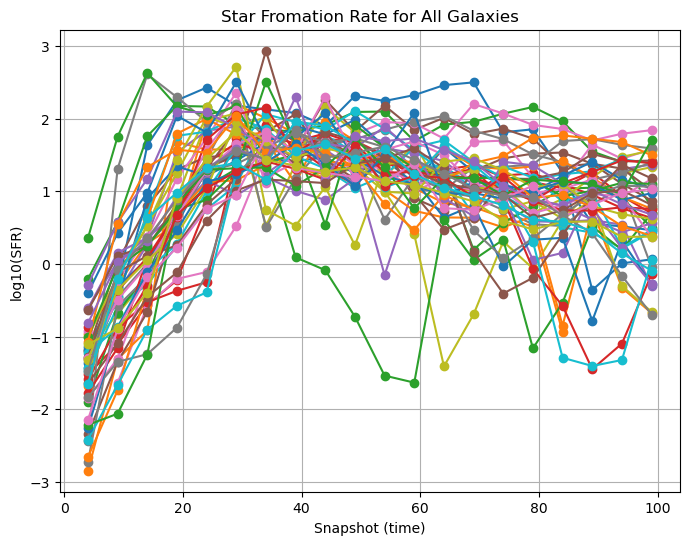

In [15]:
# Get the unique galaxy IDs
unique_galaxy_ids = df_timeseries["galaxy_id"].unique()

plt.figure(figsize=(8, 6))

for gid in unique_galaxy_ids:
    # Filter rows for this galaxy ID
    gal_data = df_timeseries[df_timeseries["galaxy_id"] == gid].copy()
    
    # (Optional) sort by snapshot, in case it's not already sorted
    gal_data.sort_values(by="snapshot", inplace=True)
    
    # Compute log10(stellar_mass)
    log_stellar_mass = np.log10(gal_data["sfr"])
    
    # Plot snapshot vs. log10(stellar_mass)
    plt.plot(gal_data["snapshot"], log_stellar_mass, marker='o', label=f"Galaxy {gid}")

plt.xlabel("Snapshot (time)")
plt.ylabel("log10(SFR)")
plt.title("Star Fromation Rate for All Galaxies")
# plt.legend()
plt.grid(True)
plt.show()

In [16]:
import skfda

gal_curves = np.log10(df_timeseries[["sfr"]]).to_numpy()
gal_times = df_timeseries[["snapshot"]].to_numpy()

df_timeseries["log_sfr"] = np.log10(df_timeseries["sfr"])

gal_curves_df = df_timeseries.pivot(index="galaxy_id", columns="snapshot", values="log_sfr")
gal_curves = gal_curves_df.to_numpy()
timepoints = gal_curves_df.columns.to_numpy()


#print(gal_curves)
#print(len(gal_times))
fd = skfda.FDataGrid(data_matrix=gal_curves, grid_points=timepoints)
print(type(fd))

/home/tnguser/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/tnguser/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'skfda.representation.grid.FDataGrid'>


In [17]:
# fd
print(fd.n_samples)  # number of galaxies
# fd.n_points   # number of timepoints (snapshots)
print(fd.grid_points)  # the snapshot values

50
(array([ 4.,  9., 14., 19., 24., 29., 34., 39., 44., 49., 54., 59., 64.,
       69., 74., 79., 84., 89., 94., 99.]),)


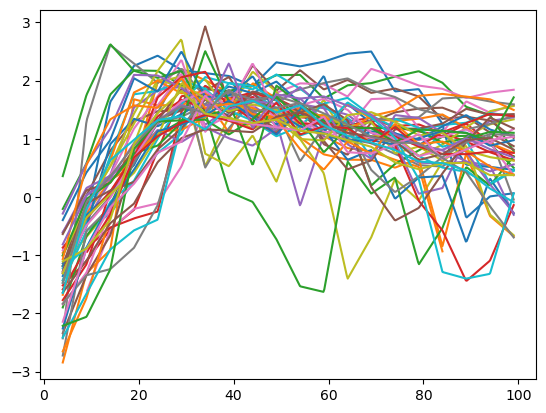

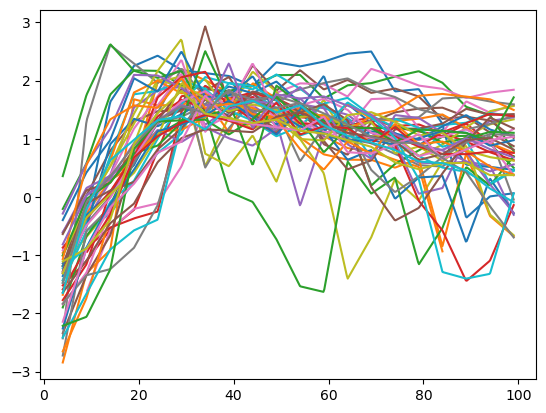

In [18]:
fd.plot()

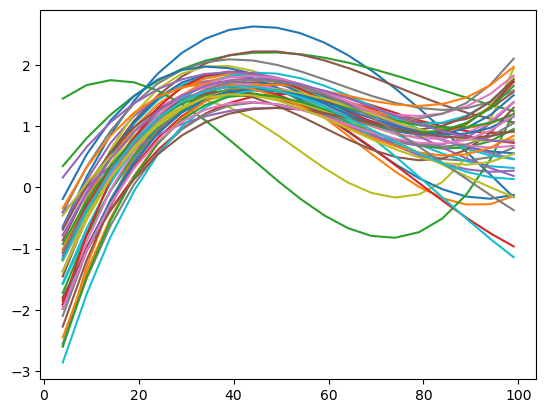

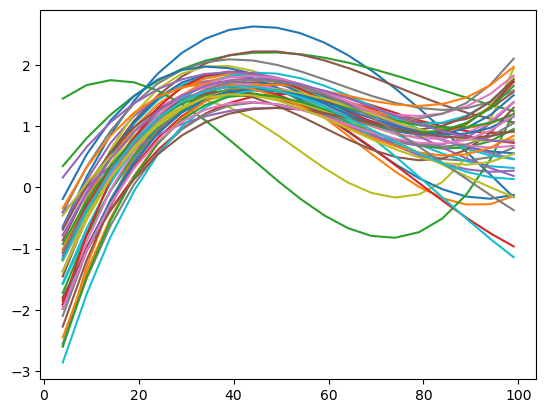

In [19]:
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import BSplineBasis

basis = BSplineBasis(n_basis=10)  # you can increase this
smoother = BasisSmoother(basis=basis)
fd_smooth = smoother.fit_transform(fd)
X = fd_smooth.data_matrix[..., 0]  # shape: (n_galaxies, n_timepoints)

fd_smooth.plot()

In [20]:
# Check how many curves do not having missing values
mask_valid = np.isfinite(X).all(axis=1)
print(f"Valid curves: {np.sum(mask_valid)} / {X.shape[0]}")

# Only take curves that have no missing values 
X_clean = X[mask_valid]
fd_clean = fd_smooth[mask_valid]

Valid curves: 47 / 50


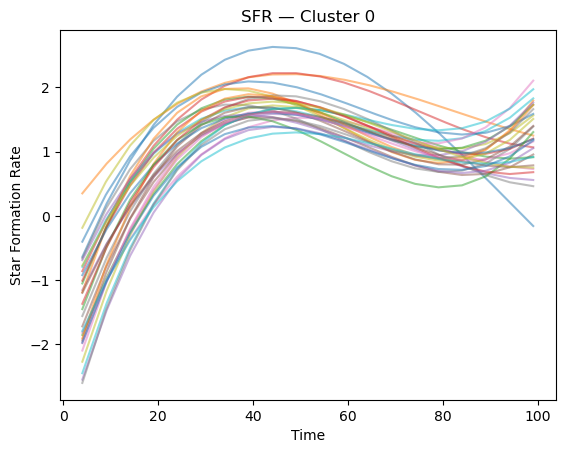

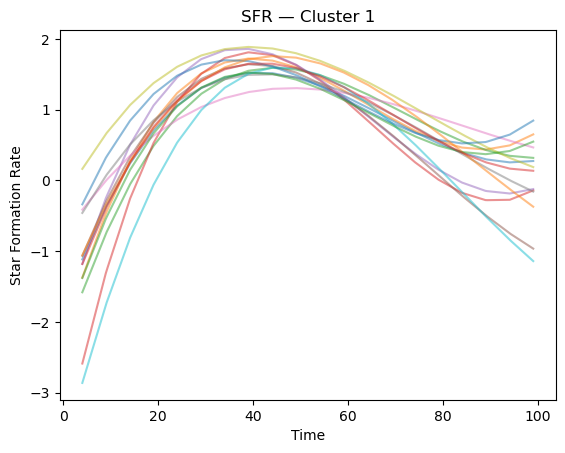

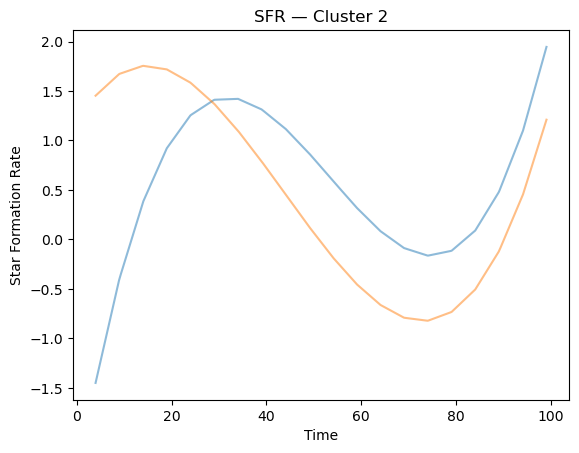

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
labels = kmeans.fit_predict(X_clean)

for c in np.unique(labels):
    fig, ax = plt.subplots()

    fd_clean[labels == c].plot(
        axes=ax,
        label=f"Cluster {c}",
        alpha=0.5
    )

    ax.set_title(f"SFR — Cluster {c}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Star Formation Rate")

    plt.show()


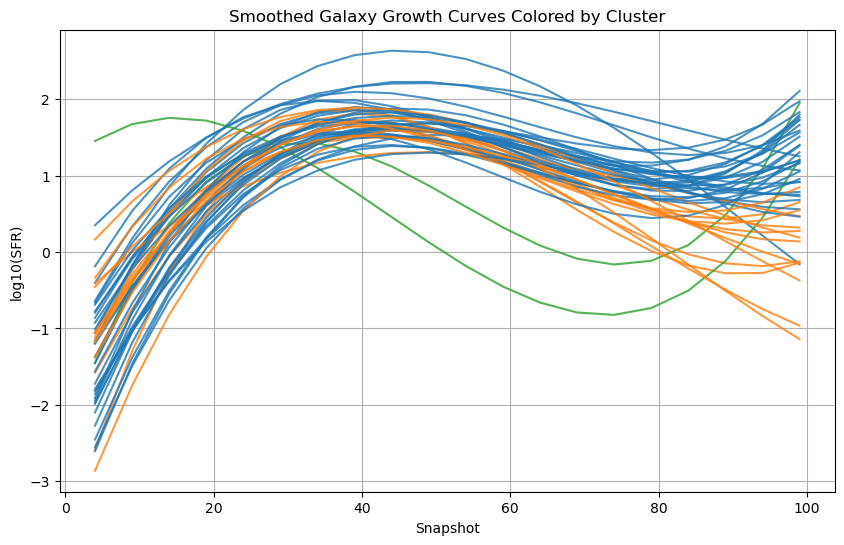

In [24]:
# Let us put the curves on top of each other 
time = fd_clean.grid_points[0] 

# Get the smoothed data matrix
Y = fd_clean.data_matrix[..., 0]  # shape: (n_galaxies, n_timepoints)
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10(labels)

# Plot each galaxy curve, colored by cluster
for i in range(Y.shape[0]):
    ax.plot(time, Y[i], color=colors[i], alpha=0.8)

ax.set_title("Smoothed Galaxy Growth Curves Colored by Cluster")
ax.set_xlabel("Snapshot")
ax.set_ylabel("log10(SFR)")
ax.grid(True)

fig.savefig(
    "galaxy_growth_clusters.pdf",  # output filename
    format="pdf",                  # file format
    bbox_inches="tight"            # trim whitespace
)

plt.show()
plt.close(fig)

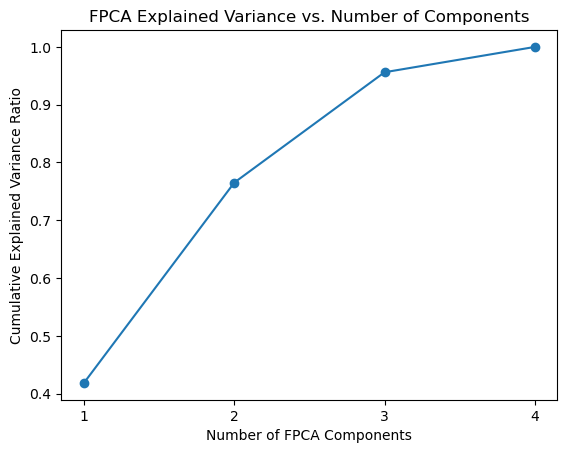

In [25]:
from skfda import FDataGrid
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
# Range of components to try
n_components = range(1, 5)
cumulative_variance = []

# Fit FPCA for each and record cumulative explained variance
for n in n_components:
    fpca = FPCA(n_components=n)
    fpca.fit(fd_clean)
    cumulative_variance.append(fpca.explained_variance_ratio_.sum())

# Plot
plt.figure() 
plt.plot(list(n_components), cumulative_variance, marker= "o")
plt.xticks(list(n_components))
plt.xlabel('Number of FPCA Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('FPCA Explained Variance vs. Number of Components')
plt.savefig("exp_var_fpca.pdf", format="pdf", bbox_inches="tight")
plt.show()

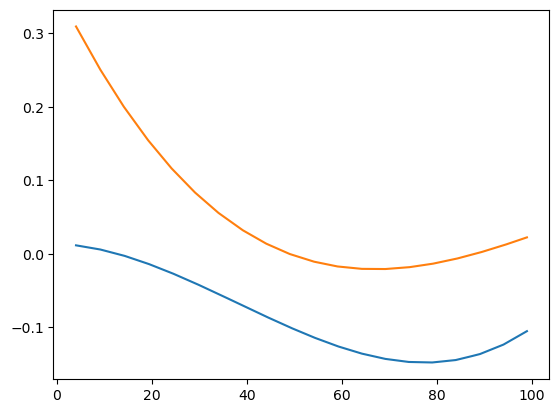

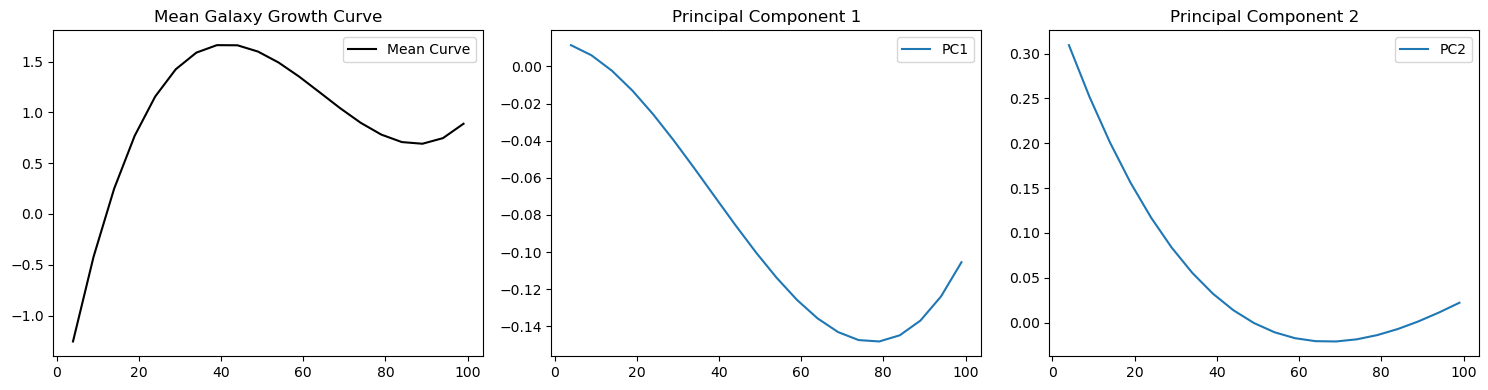

Explained variance ratios: [0.41855319 0.34659128]
Total explaiend variance is:  0.7651444692106435


In [28]:
# Get some visual aid 
fpca = FPCA(n_components=2)
fpca.fit(fd_clean)
fpca.components_.plot()

# FPCA results
mean_curve = fpca.mean_.data_matrix.flatten()
principal_components = fpca.components_

# Visualizing FPCA results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(time, mean_curve, label='Mean Curve', color='black')
axes[0].set_title('Mean Galaxy Growth Curve')
axes[0].legend()

for i in range(2):
    axes[i + 1].plot(time, principal_components[i].data_matrix.flatten(), label=f'PC{i+1}')
    axes[i + 1].set_title(f'Principal Component {i+1}')
    axes[i + 1].legend()

plt.tight_layout()
plt.show()

explained_variance_ratio = fpca.explained_variance_ratio_
print("Explained variance ratios:", explained_variance_ratio)

# Can get the total amount of varaition they account for with the following
print("Total explaiend variance is: ", sum(explained_variance_ratio))

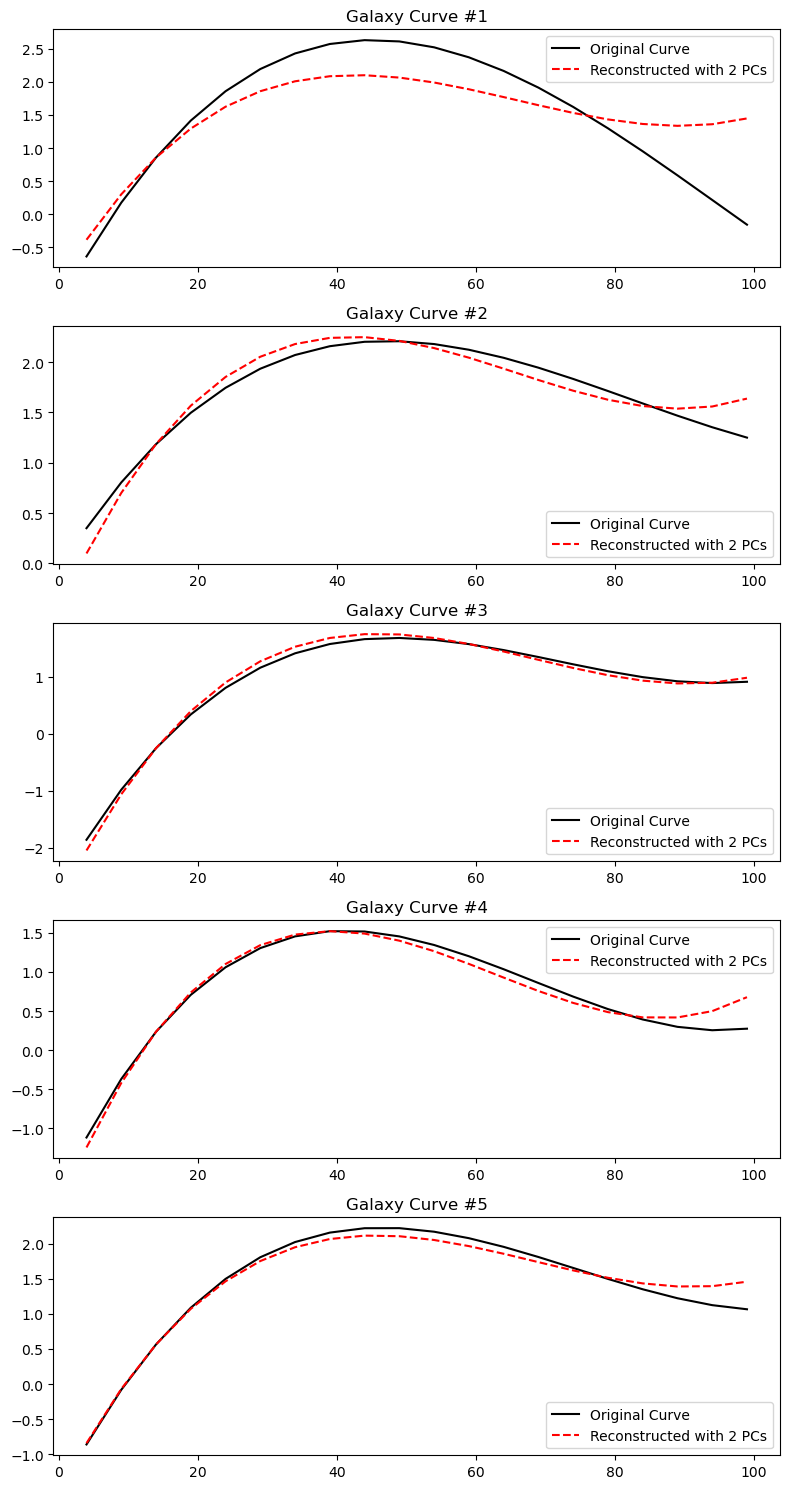

In [29]:
# Obtain the mean curve so we can use it in curve reconstruction 
mean_curve = fpca.mean_.data_matrix.flatten()
# This projects the curves onto the functional components defined above 
scores = fpca.transform(fd_clean)
# This gets the actual components from above 
components = fpca.components_.data_matrix.squeeze() 

# USe the formula from the paper 
K = 2  
reconstructed_curves = np.dot(scores[:, :K], components[:K, :]) + mean_curve

# Plot original vs reconstructed for a few curves
n_plot = 5
time_points = fd_clean.grid_points[0]

fig, axes = plt.subplots(n_plot, 1, figsize=(8, n_plot * 3))

for i in range(n_plot):
    axes[i].plot(time_points, fd_clean.data_matrix[i].flatten(), label='Original Curve', color='black')
    axes[i].plot(time_points, reconstructed_curves[i], label=f'Reconstructed with {K} PCs', linestyle='--', color='red')
    axes[i].legend()
    axes[i].set_title(f'Galaxy Curve #{i+1}')

plt.tight_layout()
plt.show()

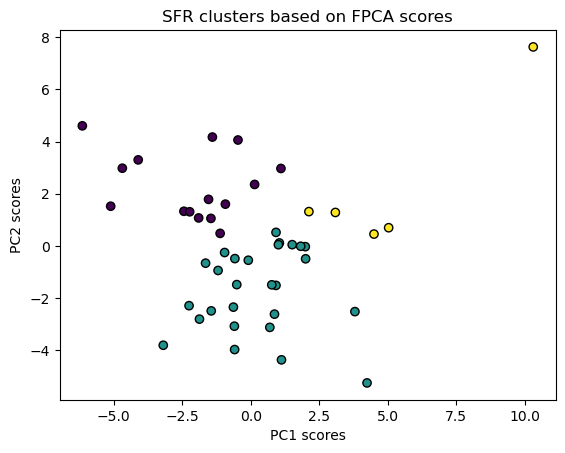

In [30]:
# We can cluster the curves once more like we did above but with the FPCA curves instead 

scores_pca = fpca.transform(fd_clean)

kmeans = KMeans(n_clusters=3, n_init = "auto", random_state=42)
clusters_pca = kmeans.fit_predict(scores_pca)

# plot them
plt.scatter(scores_pca[:,0], scores_pca[:,1], c=clusters_pca, cmap='viridis', edgecolor='k')
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.title('SFR clusters based on FPCA scores')
plt.savefig("PCA_CLuster.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Did it agree with the raw scores? 
np.mean(clusters_pca == labels)

In [33]:
from sklearn.metrics import silhouette_score

# Raw data (shape: galaxies × timepoints)
raw_data = fd_clean.data_matrix.squeeze()

# Perform clustering directly on raw data
kmeans_raw = KMeans(n_clusters=3, n_init= "auto",  random_state=42)
clusters_raw = kmeans_raw.fit_predict(raw_data)

# Silhouette score on raw data
silhouette_raw = silhouette_score(raw_data, clusters_raw)
print(f"Silhouette Score (Raw data): {silhouette_raw:.3f}")

Silhouette Score (Raw data): 0.231


In [32]:

scores_fpca = fpca.transform(fd_clean)

# Perform clustering on FPCA scores
kmeans_fpca = KMeans(n_clusters=3, n_init = "auto", random_state=42)
clusters_fpca = kmeans_fpca.fit_predict(scores_fpca)

# Silhouette score on FPCA scores
silhouette_fpca = silhouette_score(scores_fpca, clusters_fpca)
print(f"Silhouette Score (FPCA): {silhouette_fpca:.3f}")

Silhouette Score (FPCA): 0.380
